### Notebook for the label transfer of Healthy Human PBMCs to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240220

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
#from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 9.4.0
absl                NA
asttokens           NA
attr                23.2.0
chex                0.1.85
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
importlib_resources NA
ipykernel           6.29.2
ipywidgets          8.1.2
jax                 0.4.24
jaxlib              0.4.24
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
mizani              0.9.3
ml_collections      NA
ml_dtypes           0.3.2
mpl_toolkits        NA
msgpack             1.0.7
mudata           

In [3]:
 def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [4]:
torch.set_float32_matmul_precision('high')

In [5]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [6]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [7]:
reference = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Annotated_PBMC/meyer_nikolic_covid_pbmc_raw.h5ad')
reference

AnnData object with n_obs × n_vars = 422220 × 33559
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight'
    var: 'name'

In [8]:
X_is_raw(reference)

True

In [13]:
reference.obs['annotation_detailed_fullNames'].value_counts()

annotation_detailed_fullNames
T CD4 naive                           77439
Classical monocyte                    47520
NK                                    43630
B naive                               40193
T CD4 helper                          37922
T CD8 CTL                             36217
T CD8 naive                           33590
T CD8 central mem                     12830
T regulatory                           8567
Non-classical monocyte                 8342
T CD4 naive IFN stim                   8134
Classical monocyte IFN stim            7124
T CD8 effector mem CD45RA+             6443
B non-switched mem                     5574
T CD4 CTL                              5294
T gamma/delta                          5144
NK CD56 bright                         4723
B switched mem                         4060
MAIT                                   3961
Cycling                                3593
cDC2                                   2963
T CD8 effector mem                     2486
B 

In [14]:
reference.obs['annotation_detailed_fullNames'].cat.categories

Index(['Hematopoietic progenitors IFN stim', 'B non-switched mem IFN stim',
       'B naive IFN stim', 'Non-classical monocyte IFN stim',
       'Classical monocyte IFN stim', 'NK IFN stim', 'T CD8 CTL IFN stim',
       'T CD4 naive IFN stim', 'Red blood cells', 'Platelets', 'Cycling',
       'Basophils & Eosinophils', 'Hematopoietic progenitors', 'Plasmablasts',
       'Plasma cells', 'B invariant', 'B switched mem', 'B non-switched mem',
       'B naive', 'cDC2', 'cDC1', 'AS-DC', 'pDC',
       'Non-classical monocyte complement+', 'Non-classical monocyte',
       'Classical monocyte IL6+', 'Classical monocyte', 'ILC',
       'NK CD56 bright', 'NK', 'NKT', 'MAIT', 'T regulatory', 'T gamma/delta',
       'T CD8 CTL', 'T CD8 effector mem CD45RA+', 'T CD8 effector mem',
       'T CD8 central mem', 'T CD8 naive', 'T CD4 CTL', 'T CD4 helper',
       'T CD4 naive'],
      dtype='object')

In [15]:
reference.obs['seed_labels'] = reference.obs['annotation_detailed_fullNames'].copy()
reference.obs['seed_labels'].value_counts()

seed_labels
T CD4 naive                           77439
Classical monocyte                    47520
NK                                    43630
B naive                               40193
T CD4 helper                          37922
T CD8 CTL                             36217
T CD8 naive                           33590
T CD8 central mem                     12830
T regulatory                           8567
Non-classical monocyte                 8342
T CD4 naive IFN stim                   8134
Classical monocyte IFN stim            7124
T CD8 effector mem CD45RA+             6443
B non-switched mem                     5574
T CD4 CTL                              5294
T gamma/delta                          5144
NK CD56 bright                         4723
B switched mem                         4060
MAIT                                   3961
Cycling                                3593
cDC2                                   2963
T CD8 effector mem                     2486
B naive IFN stim    

In [17]:
trans_from = [['T CD4 naive IFN stim', 'T CD4 CTL', 'T CD4 helper','T CD4 naive'],             #CD4
              ['T CD8 CTL IFN stim', 'MAIT', 'T CD8 CTL', 'T CD8 effector mem CD45RA+', 'T CD8 effector mem', 'T CD8 central mem', 'T CD8 naive'],             #CD8
              ['T regulatory', 'T gamma/delta'],                                               #Treg
              ['NK IFN stim', 'NK CD56 bright', 'NK'],                                         #NK
              ['NKT'],                                                                         #NKT
              ['ILC'],                                                                         #ILC   
              ['Non-classical monocyte IFN stim', 'Classical monocyte IFN stim', 'Non-classical monocyte complement+', 'Non-classical monocyte', 'Classical monocyte IL6+', 'Classical monocyte'],             #Monocytes
              ['B non-switched mem IFN stim', 'B naive IFN stim', 'B invariant', 'B switched mem', 'B non-switched mem', 'B naive'],             #B cells
              ['pDC'],                                                                         #pDCs
              ['cDC2', 'cDC1', 'AS-DC'],                                                       #DC
              ['Plasmablasts', 'Plasma cells'],                                                #Plasma cells
              ['Hematopoietic progenitors IFN stim', 'Red blood cells', 'Cycling','Hematopoietic progenitors'],  #Hematopoetic
              ['Platelets'],                                                                   #Platelets
              ['Basophils & Eosinophils',]]                                                    #Basophils_Eosinophils

trans_to = ['CD4+T', 'CD8+T', 'Treg', 'NK', 'NKT', 'ILC','Monocytes', 'B_cells', 'pDC', 'DC', 'Plasma_cells', 'Hematopoetic', 'Platelets','Baso_Eosino']

reference.obs['seed_labels'] = [str(i) for i in reference.obs['annotation_detailed_fullNames']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        reference.obs['seed_labels'][reference.obs['seed_labels'] == leiden_from] = celltype

- Remove annotations with less than 10 cells

In [19]:
reference.obs['seed_labels'].value_counts()
#reference.obs['seed_labels'].cat.categories

seed_labels
CD4+T           128789
CD8+T            95661
Monocytes        66094
B_cells          54470
NK               49564
Treg             13711
Hematopoetic      4937
DC                3083
Platelets         1784
Plasma_cells      1765
pDC               1245
NKT                687
ILC                405
Baso_Eosino         25
Name: count, dtype: int64

### Subset populations of interest

In [20]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells?
reference.obs['seed_labels'].value_counts()

seed_labels
CD4+T           128789
CD8+T            95661
Monocytes        66094
B_cells          54470
NK               49564
Treg             13711
Hematopoetic      4937
DC                3083
Platelets         1784
Plasma_cells      1765
pDC               1245
NKT                687
ILC                405
Baso_Eosino         25
Name: count, dtype: int64

In [21]:
reference.obs['donor'] = reference.obs['patient_id'].copy()

In [22]:
sc.pp.filter_cells(reference, min_genes = 200)              #to remove empty cells from table
sc.pp.filter_cells(reference, min_counts = 100)

In [23]:
cell_source_reference = "Yoshida"
reference.obs["cell_source"] = cell_source_reference
reference.obs['cell_source'].value_counts()

cell_source
Yoshida    422220
Name: count, dtype: int64

### Read in other query

In [25]:
query = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Merge+Subset_Ctrls_demux_QCed_ac240221.raw.h5ad')
query.obs['cell_source'] = 'AG_Gerull'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    layers: 'counts', 'sqrt_norm'

In [26]:
X_is_raw(query)

True

In [27]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [28]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [29]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 430067 × 16209
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'donor', 'n_genes', 'n_counts', 'cell_source', 'sample', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-

In [30]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
CD4+T           128789
CD8+T            95661
Monocytes        66094
B_cells          54470
NK               49564
Treg             13711
Unknown           7847
Hematopoetic      4937
DC                3083
Platelets         1784
Plasma_cells      1765
pDC               1245
NKT                687
ILC                405
Baso_Eosino         25
Name: count, dtype: int64

In [31]:
adata.obs['batch'].value_counts()

batch
reference    422220
query          7847
Name: count, dtype: int64

### Select HVGs

In [32]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
AP6               15700
AP11              12207
PP3               10293
AP5               10097
AP12              10033
                  ...  
AN1                 915
Pkp2_Ctr_PBS_3      909
Pkp2_Ctr_PBS_1      684
PC27                431
PP11                 72
Name: count, Length: 86, dtype: int64

In [33]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 430067 × 7000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'donor', 'n_genes', 'n_counts', 'cell_source', 'sample', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A

### Transfer of annotation with scANVI

In [34]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [35]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [37]:
scvi_model.train(20, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 20/20: 100%|██████████| 20/20 [05:31<00:00, 14.78s/it, v_num=1, train_loss_step=2.33e+3, train_loss_epoch=2.32e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [05:31<00:00, 16.57s/it, v_num=1, train_loss_step=2.33e+3, train_loss_epoch=2.32e+3]


### Evaluate model performance a la _Sevensson_

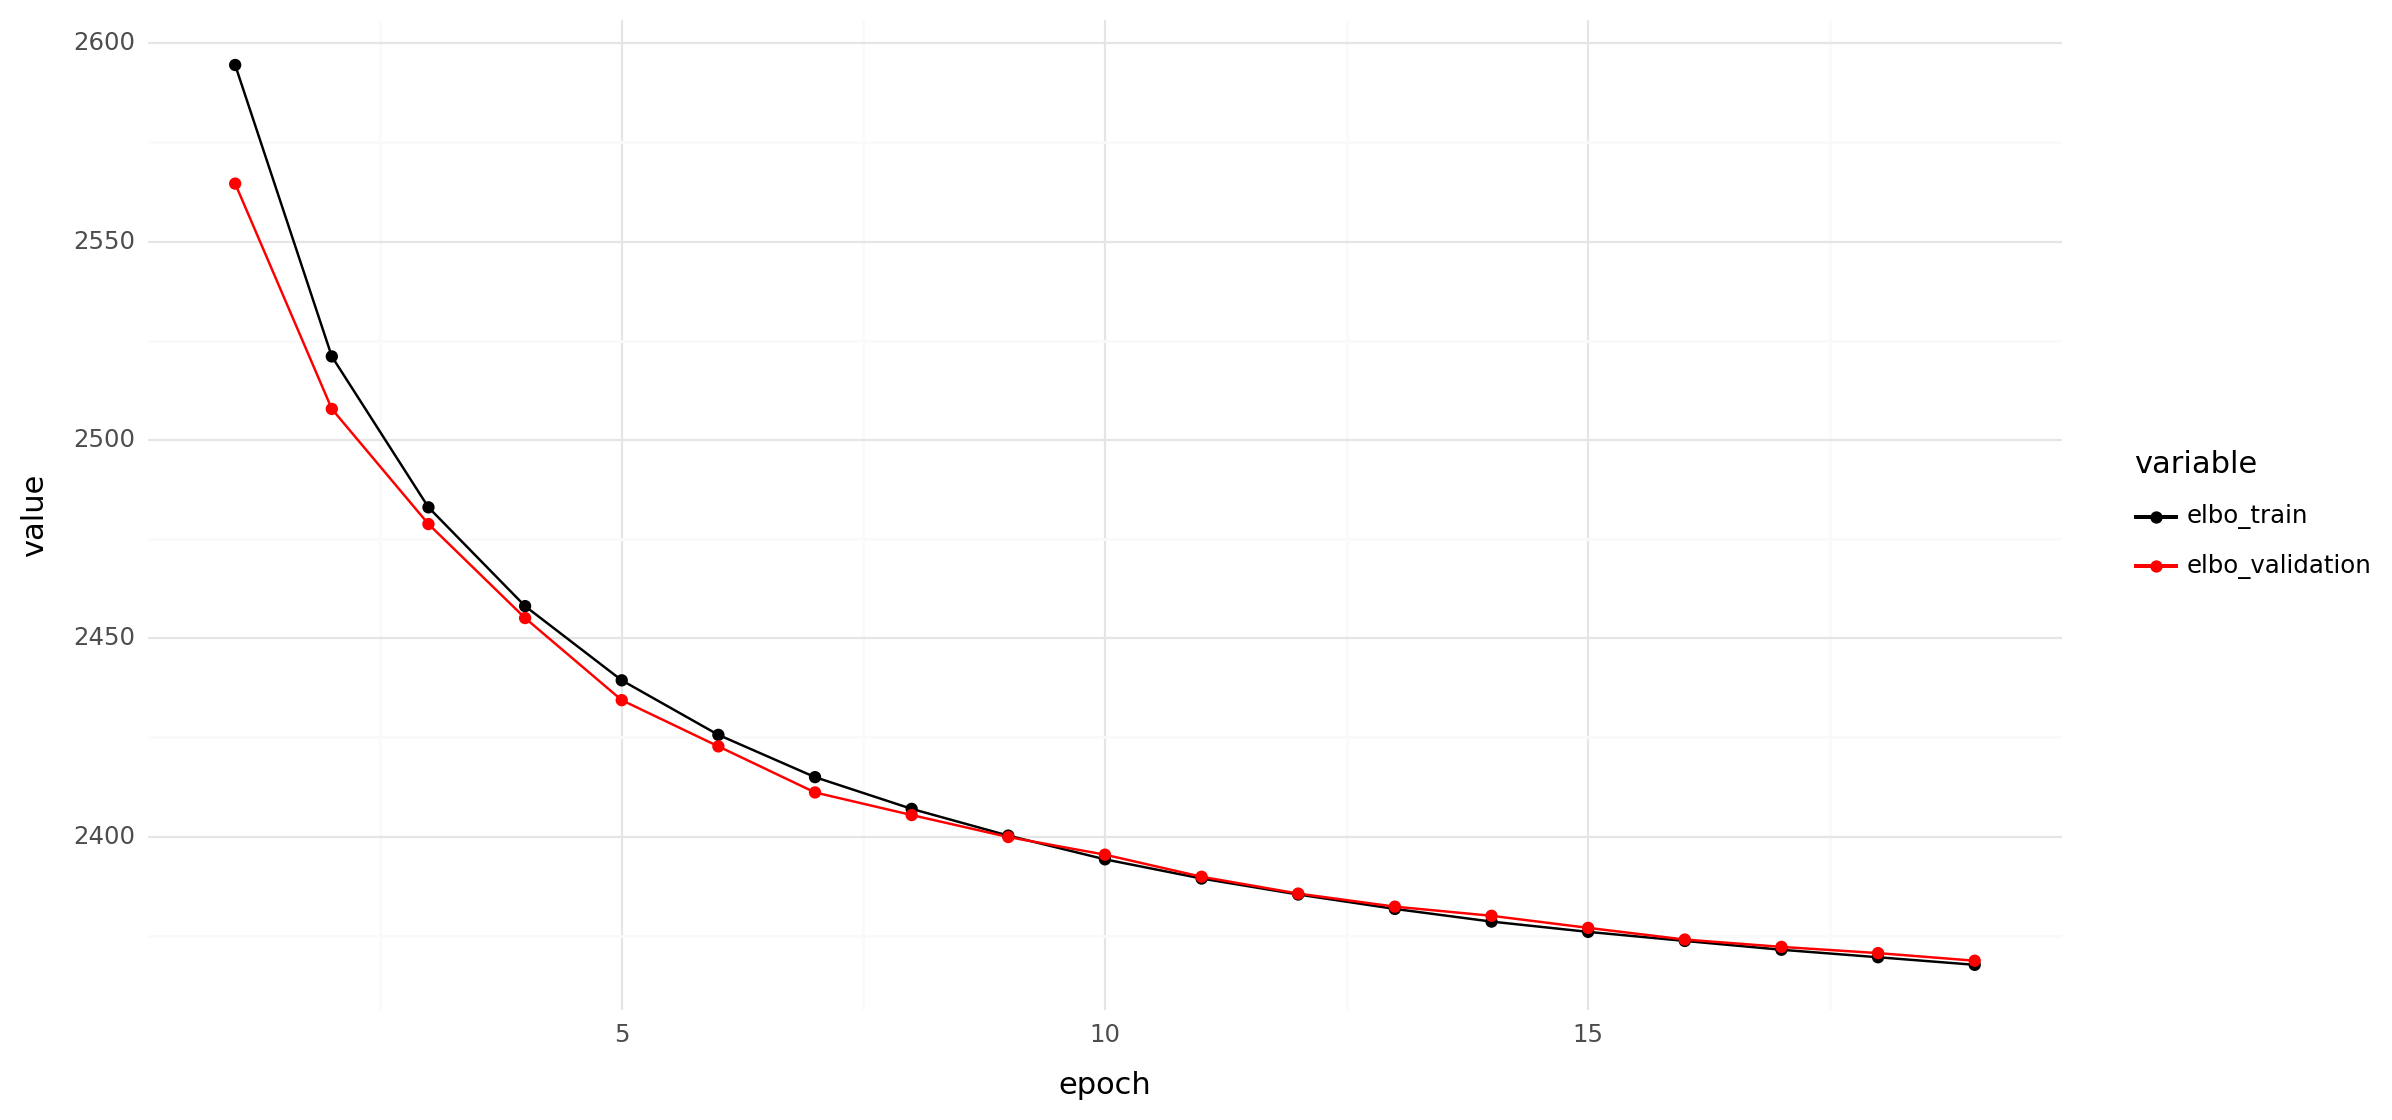

In [38]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('scVI_20epochs.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [39]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [40]:
scanvi_model.train(20, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 20/20: 100%|██████████| 20/20 [16:36<00:00, 50.69s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=2.31e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [16:36<00:00, 49.85s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=2.31e+3]


### Evaluate model performance a la Svensson

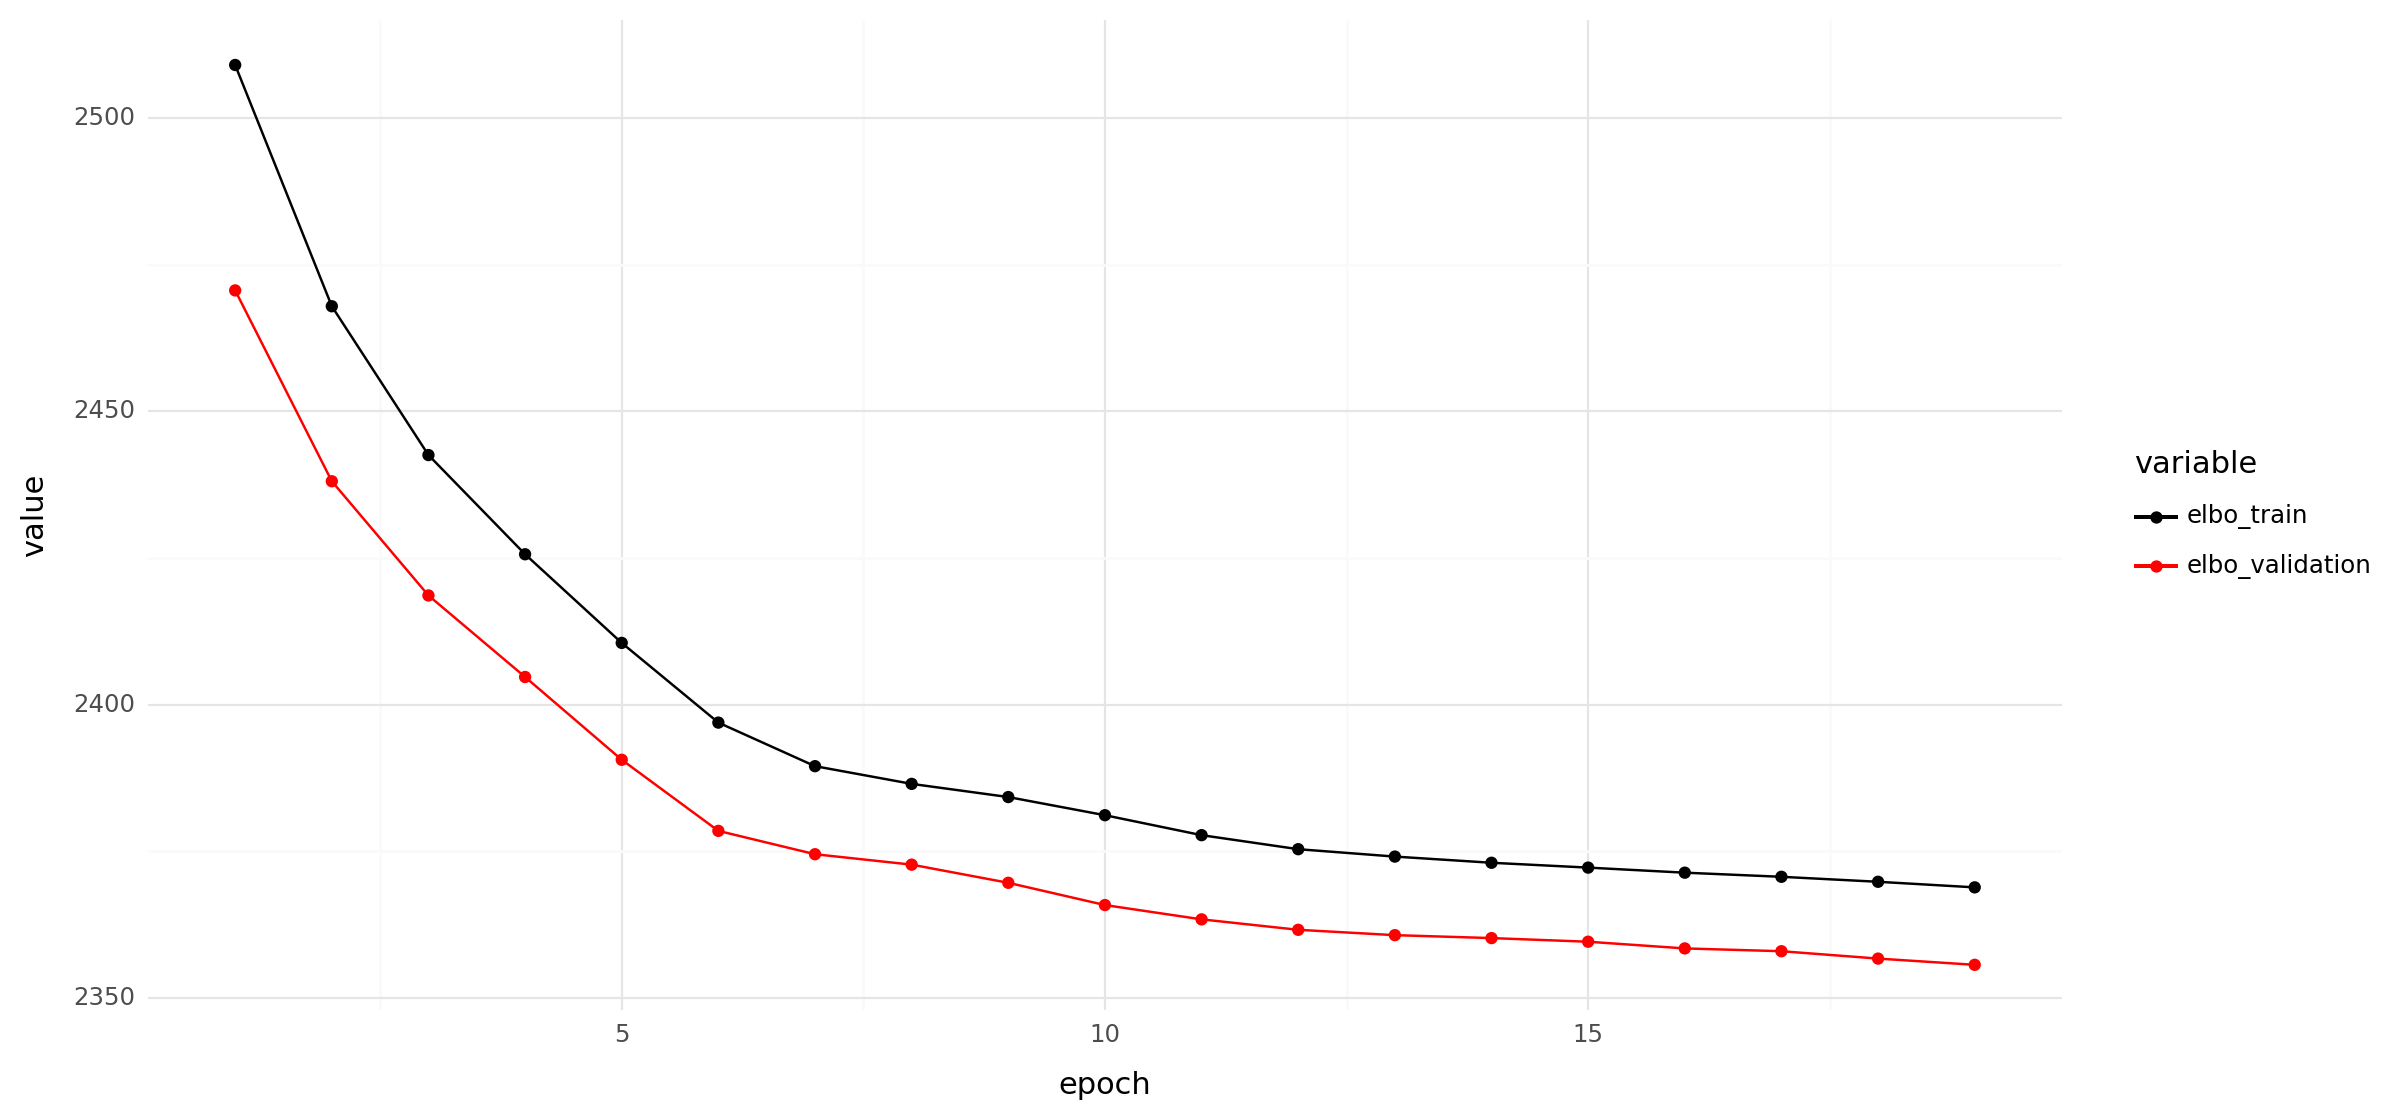

In [41]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('scANVI_20epochs.png', dpi = 300)

print(p_)

In [42]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [43]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [45]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:48)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:05)


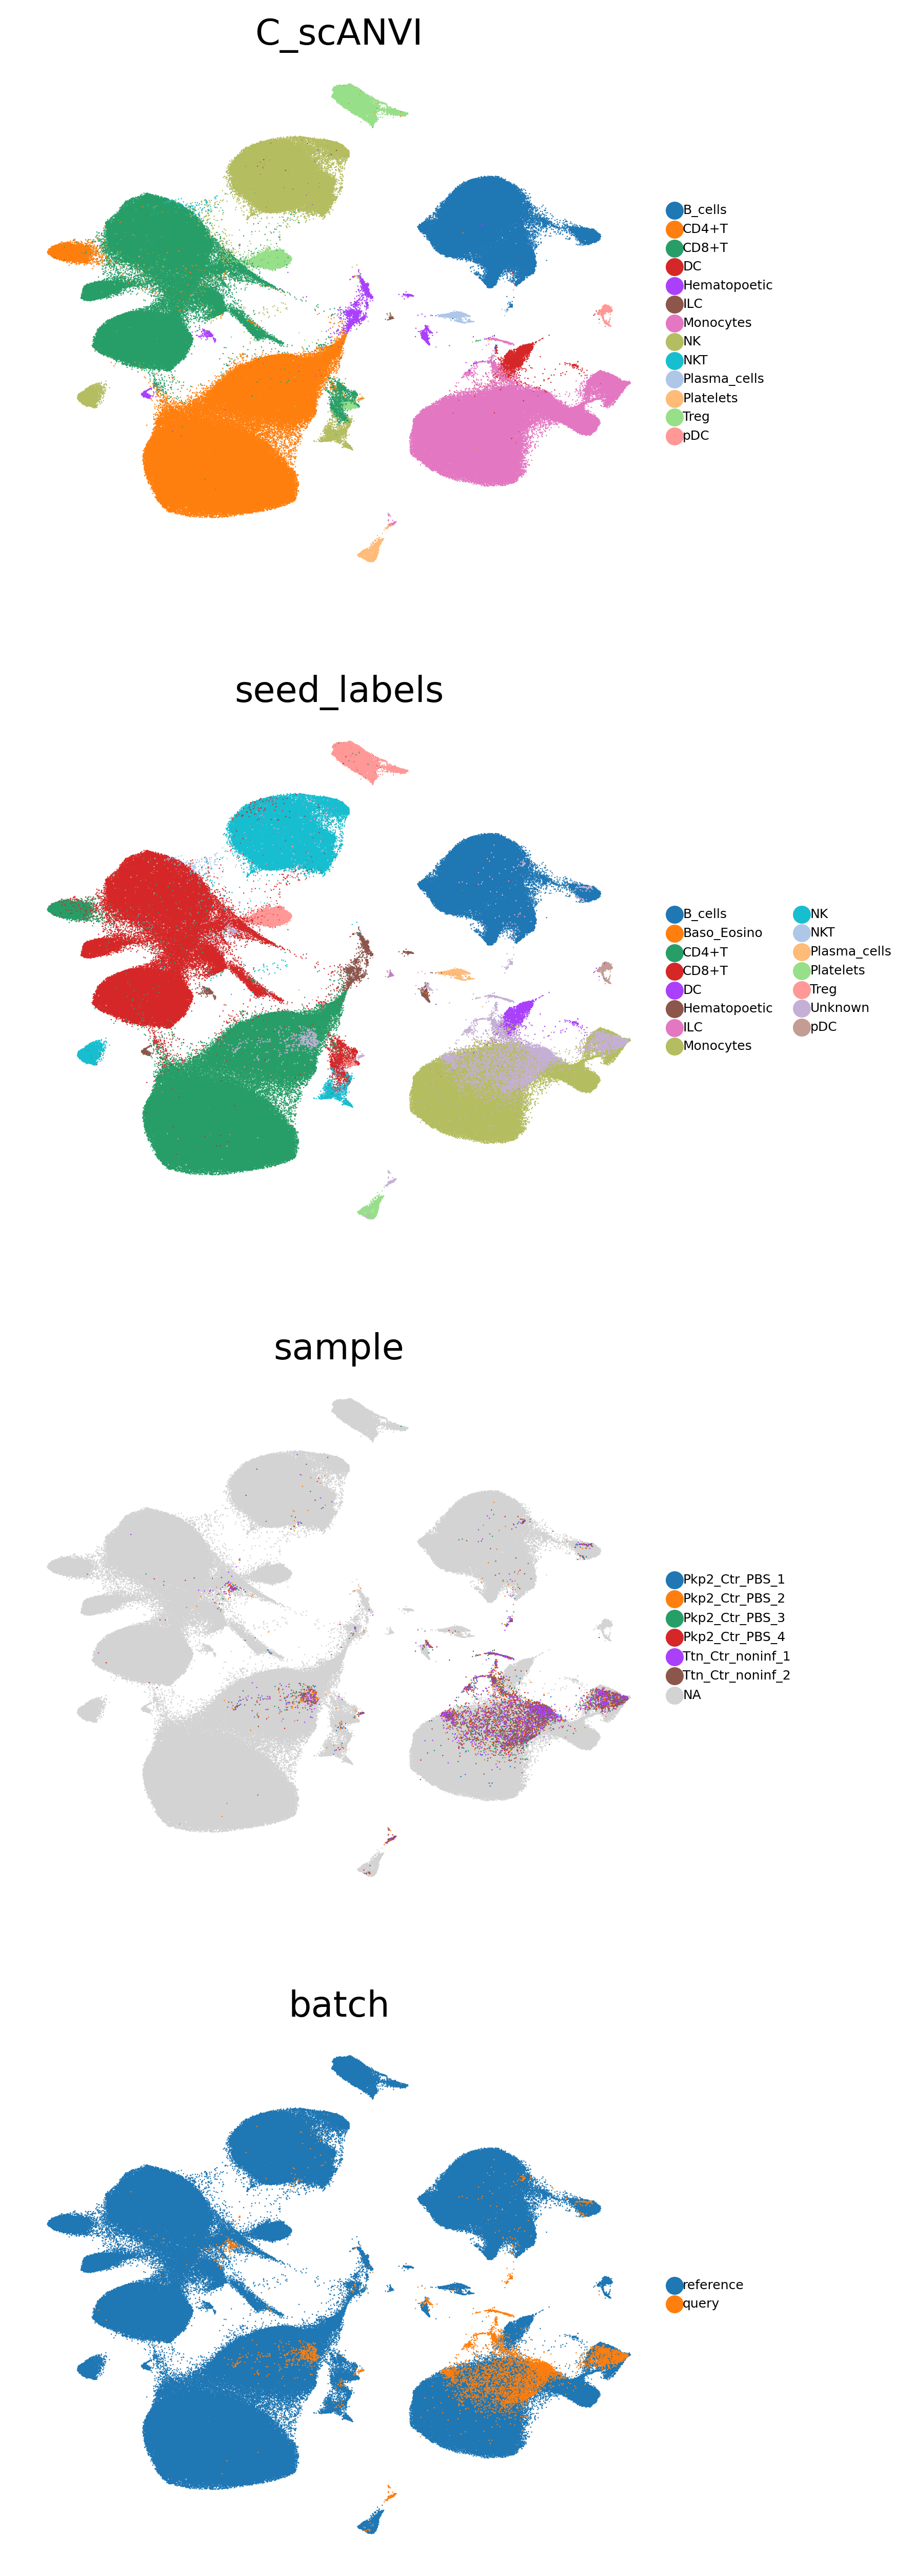

In [46]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'sample', 'batch'], size = 1, legend_fontsize = 5, ncols = 1)

### Export annotated object

In [47]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

AnnData object with n_obs × n_vars = 430067 × 16209
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'donor', 'n_genes', 'n_counts', 'cell_source', 'sample', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_

In [48]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

View of AnnData object with n_obs × n_vars = 7847 × 16209
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'donor', 'n_genes', 'n_counts', 'cell_source', 'sample', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query',

### Add new gene symbols

In [49]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'donor', 'n_genes', 'n_counts', 'cell_source', 'sample', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A

### Revert gene symbols

In [50]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [51]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
Monocytes       6234
CD4+T            492
B_cells          314
Platelets        204
CD8+T            185
DC               176
Hematopoetic     119
NK                61
Treg              36
Plasma_cells      24
ILC                1
pDC                1
Name: count, dtype: int64

In [52]:
query_export

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'Smoker', 'annotation_broad', 'annotation_detailed', 'annotation_detailed_fullNames', 'patient_id', 'sample_id', 'sequencing_library', 'Protein_modality_weight', 'seed_labels', 'donor', 'n_genes', 'n_counts', 'cell_source', 'sample', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A

In [53]:
query_export.obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,Age_group,BMI,COVID_severity,COVID_status,Ethnicity,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACCCAAGATACAGT-1-A1-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.662696,0.019038,0.000000,0.0,-0.339369,-0.496060,query,81,14,CD4+T
AAACGCTGTTGTGTTG-1-A1-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query,80,14,Monocytes
AAACGCTTCTCGCTCA-1-A1-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,query,80,14,Monocytes
AAAGGTACAGAACATA-1-A1-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.213276,0.027315,0.051323,0.0,-0.317631,-0.578954,query,81,14,Monocytes
AAAGTCCAGGGACACT-1-A1-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370085,query,81,14,Monocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291862,query,85,14,Monocytes
TTTGGTTTCCTGTACC-1-B2-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,85,14,Monocytes
TTTGTTGCAAGCTCTA-1-B2-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,84,14,DC
TTTGTTGTCCCAGGAC-1-B2-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,85,14,Monocytes


In [54]:
query_export.write('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Merge+Subset_Ctrls_scANVI_cellstates_ac240221.raw.h5ad')